# Libraries

In [48]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             confusion_matrix, roc_curve, auc)
from sklearn.inspection import permutation_importance

# Setup

In [49]:
plt.rcParams.update({'font.size': 20})

In [50]:
# Load test dataset
df_test = pd.read_parquet("../data/final/test_data.parquet")

# Drop classification target to avoid leakage
df_test = df_test.drop(columns=['DepDelayMinutes'])

# Extract features and target
X_test = df_test.drop(columns=['DepDel15'])
y_test = df_test['DepDel15'].values.ravel()

In [51]:
classification_models_base = {
    "Log Regression (Base)": "../models/log_reg/log_reg_base.pkl",
    "SGD (Base)": "../models/sgd_clf/sgd_clf_base.pkl",
    "HGB (Base)": "../models/hgb_clf/hgb_clf_base.pkl",
    "MLP (Base)": "../models/mlp_clf/mlp_clf_base.pkl"
}

classification_models = {
    "Log Regression": "../models/log_reg/log_reg_tuned.pkl",
    "SGD": "../models/sgd_clf/sgd_clf_tuned.pkl",
    "HGB": "../models/hgb_clf/hgb_clf_tuned.pkl",
    "MLP": "../models/mlp_clf/mlp_clf_tuned.pkl"
}

# Helper Functions

In [52]:
def clf_evaluater(models_dict, X_test, y_test):
    """Loads and evaluates classification models, returns model predictions."""
    classification_results = []
    model_predictions = {}

    for model_name, file in models_dict.items():
        with open(file, "rb") as f:
            model = pickle.load(f)

        # Make predictions
        y_pred = model.predict(X_test)
        model_predictions[model_name] = y_pred  # Store standard predictions

        # Store probability estimates if available
        if hasattr(model, "predict_proba"):
            model_predictions[model_name + " Prob"] = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            model_predictions[model_name + " Prob"] = model.decision_function(X_test)

        # Compute evaluation metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="binary")

        classification_results.append({
            "Model": model_name,
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        })

    # Return results DataFrame and predictions dictionary
    return pd.DataFrame(classification_results), model_predictions

In [53]:
def clf_performance_plotter(df_results):
    """Plots a bar chart comparing classification model performance."""
    plt.figure(figsize=(10, 6))
    ax = df_results.set_index("Model").plot(kind="bar", figsize=(10, 6))

    plt.title("Classification Model Performance Comparison")
    plt.ylabel("Metric Value")
    plt.xticks(rotation=360)
    plt.grid()

    # Adjust legend with 2x2 layout and add a title
    ax.legend(title="Metrics", loc='lower center', bbox_to_anchor=(0.5, -0.7), ncol=2)

    # Ensure enough space for legend at the bottom
    plt.subplots_adjust(bottom=0.3)

    plt.show()

In [54]:
def clf_confusion_matrices(models_dict, model_predictions, y_test):
    """Plots a 2x2 grid of confusion matrices for all models with a shared color bar and global labels."""
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()  # Flatten for easier iteration

    # Compute global color scale range
    cms = {model: confusion_matrix(y_test, model_predictions[model]) for model in models_dict.keys()}
    vmin = min(cm.min() for cm in cms.values())
    vmax = max(cm.max() for cm in cms.values())

    # Plot confusion matrices
    heatmaps = []
    for i, (model_name, cm) in enumerate(cms.items()):
        heatmap = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", ax=axes[i], 
                              vmin=vmin, vmax=vmax, cbar=False)  # Remove individual color bars
        heatmaps.append(heatmap)
        axes[i].set_title(f"{model_name}")
        axes[i].tick_params(left=False, bottom=False)  # Remove ticks

    # Set global labels
    fig.text(0.5, 0.05, "Predicted", ha='center', fontsize=24)
    fig.text(0.05, 0.5, "Actual", va='center', rotation='vertical', fontsize=24)

    # Add a single shared color bar
    cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.6])  # Adjust position
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap="Blues", norm=norm)
    sm.set_array([])
    fig.colorbar(sm, cax=cbar_ax)

    # Adjust layout
    plt.suptitle("Confusion Matrices", fontsize=24)

    plt.show()

In [55]:
def clf_auc_plotter(models_dict, model_predictions, y_test):
    """Plots ROC Curves for models that support probability estimation."""
    plt.figure(figsize=(8, 6))
    for model_name in models_dict.keys():
        prob_key = model_name + " Prob"
        if prob_key in model_predictions:
            fpr, tpr, _ = roc_curve(y_test, model_predictions[prob_key])
            plt.plot(fpr, tpr, label=f"{model_name} ({auc(fpr, tpr):.2f})")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves")
    plt.legend()
    plt.show()

In [56]:
def clf_permutation_importance(models_dict, X_test, y_test, scoring="accuracy", n_repeats=5, frac=0.1):
    """Computes permutation importance with parallel processing and ensures stratified sampling.
       Returns a DataFrame with feature importances and a DataFrame of top 5 features per model.
    """
    feature_importances = {}
    top_features = {}

    # Stratified sampling to maintain class distribution
    if frac < 1.0:
        X_test_sample, _, y_test_sample, _ = train_test_split(
            X_test, y_test, test_size=(1-frac), stratify=y_test, random_state=42
        )
    else:
        X_test_sample, y_test_sample = X_test, y_test

    for model_name, file in models_dict.items():
        with open(file, "rb") as f:
            model = pickle.load(f)

        # Compute permutation importance with parallel processing
        result = permutation_importance(
            model, X_test_sample, y_test_sample,
            scoring=scoring, n_repeats=n_repeats, random_state=42, n_jobs=-1
        )

        # Store feature importance scores
        feature_importances[model_name] = result.importances_mean

        # Get top 5 features for the current model
        sorted_indices = result.importances_mean.argsort()[::-1][:5]
        top_features[model_name] = X_test.columns[sorted_indices].tolist()

    # Convert to DataFrame
    df_importance = pd.DataFrame(feature_importances, index=X_test.columns)

    # Compute global importance ranking
    df_importance["Mean Importance"] = df_importance.mean(axis=1)
    df_importance["Feature"] = df_importance.index  # Add feature names inside the DataFrame
    df_importance["Rank"] = df_importance["Mean Importance"].rank(ascending=False)

    # Sort by mean importance
    df_importance = df_importance.sort_values(by="Mean Importance", ascending=False)

    # Reorder columns: Rank (as index), Feature, Models..., Mean Importance
    column_order = ["Feature"] + list(models_dict.keys()) + ["Mean Importance"]
    df_importance = df_importance[["Rank"] + column_order]
    
    df_importance.set_index("Rank", inplace=True)  # Set Rank as the index

    # Convert top features dictionary into DataFrame and transpose
    df_top_features = pd.DataFrame.from_dict(top_features, orient='index').T
    df_top_features.index = range(1, 6)  # Ranking from 1 to 5
    df_top_features.index.name = "Rank"  # Set index name to Rank
    
    return df_importance, df_top_features

# Results

### Base Model Results

In [57]:
df_clf_base, clf_preds_base = clf_evaluater(classification_models_base, X_test, y_test)
df_clf_base

,Model,Accuracy,Precision,Recall,F1-Score
0,Log Regression (Base),0.645945,0.651755,0.641231,0.646450
1,SGD (Base),0.642804,0.644580,0.651773,0.648157
2,HGB (Base),0.661970,0.676492,0.633123,0.654090
3,MLP (Base),0.661175,0.679325,0.622749,0.649808


### Tuned Model Results

In [58]:
df_clf_tuned, clf_preds_tuned = clf_evaluater(classification_models, X_test, y_test)
df_clf_tuned

,Model,Accuracy,Precision,Recall,F1-Score
0,Log Regression,0.645945,0.651755,0.641231,0.646450
1,SGD,0.644251,0.649532,0.641255,0.645367
2,HGB,0.666717,0.681048,0.639034,0.659373
3,MLP,0.659456,0.672839,0.633320,0.652482


## Tuned Model Plots

### Tuned Model Performance Comparison

<Figure size 1000x600 with 0 Axes>

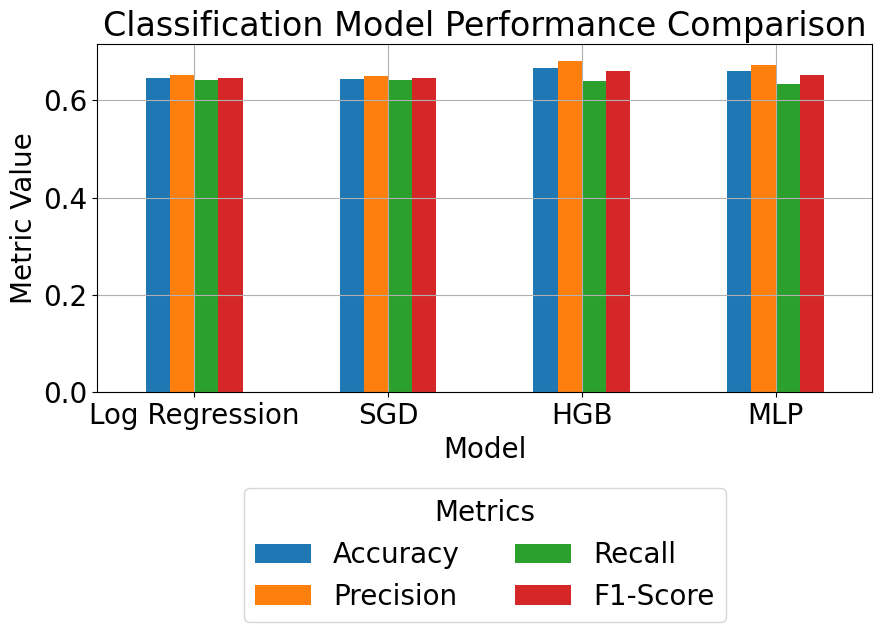

In [59]:
clf_performance_plotter(df_clf_tuned)

### Tuned Model Confusion Matricies

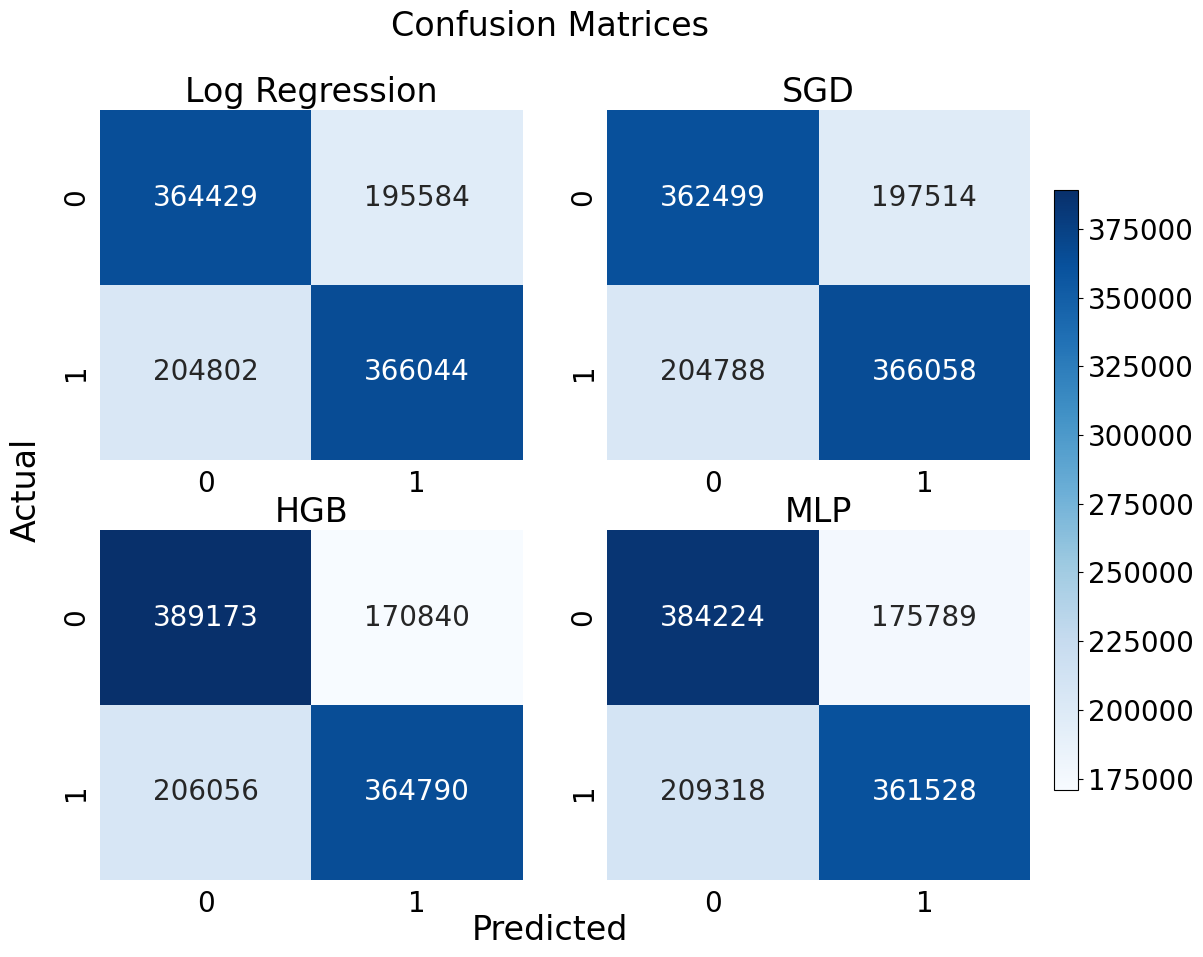

In [60]:
clf_confusion_matrices(classification_models, clf_preds_tuned, y_test)

### Tuned Model AUC-ROC Plot

c:\Users\ekait\anaconda3\envs\DSC288R_Capstone_Group09\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


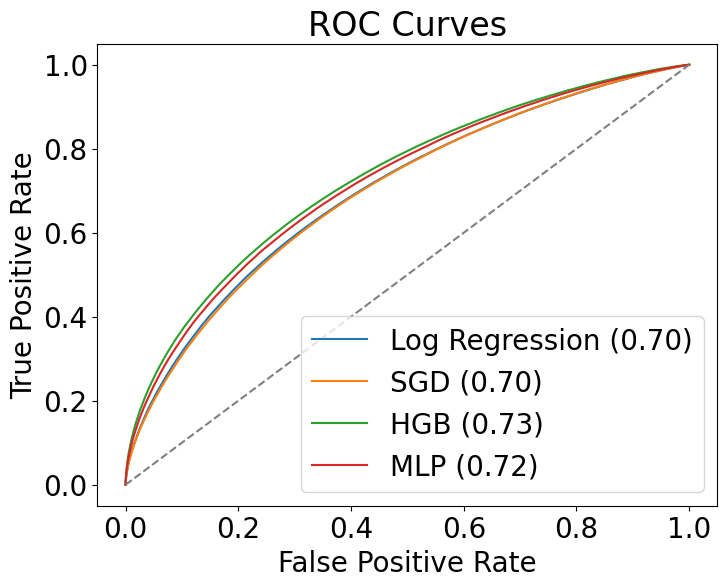

In [61]:
clf_auc_plotter(classification_models, clf_preds_tuned, y_test)

## Tuned Model Feature Importance

In [62]:
df_clf_feature_importance, df_clf_top_features = clf_permutation_importance(classification_models, X_test, y_test)

In [63]:
df_clf_feature_importance

,Feature,Log Regression,SGD,HGB,MLP,Mean Importance
Rank,,,,,,
1.0,CRSDepTime_cos,0.050528,0.035897,0.000658,0.036744,0.030957
2.0,Distance,0.022422,0.017702,0.011153,0.036337,0.021903
3.0,AirTime,0.012277,0.009481,0.011241,0.025142,0.014536
4.0,Airline,0.014467,0.007384,0.020178,0.013823,0.013963
5.0,cumulative_flights_before,0.004209,0.003778,0.013050,0.026313,0.011838
...,...,...,...,...,...,...
59.0,weekly_avg_dest_prcp,-0.000186,0.000025,0.000113,0.000311,0.000066
60.0,weekly_avg_origin_snwd,-0.000046,0.000050,-0.000078,0.000241,0.000042
61.0,AirTimeCategory,-0.000177,0.000000,0.000039,0.000249,0.000028


In [65]:
df_clf_top_features

,Log Regression,SGD,HGB,MLP
Rank,,,,
1,CRSDepTime_cos,CRSDepTime_cos,Airline,CRSDepTime_cos
2,Distance,Distance,cumulative_flights_before,Distance
3,Airline,past_100_avg_delay,AirTime,cumulative_flights_before
4,AirTime,AirTime,Distance,AirTime
5,past_100_avg_delay,Airline,Dest_PRCP,CRSDepTime
